In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


c:\Users\ssupa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.0)
  from scipy.sparse import csr_matrix, issparse


In [2]:
class PMDataset(Dataset):
    def __init__(self, values, target_idx, window_size=7):
        self.X, self.y = [], []
        for i in range(len(values) - window_size):
            self.X.append(values[i:i+window_size])
            self.y.append(values[i+window_size, target_idx])
        
        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# LSTM

In [3]:
import torch.nn as nn

class PM25_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]   # last timestep
        return self.fc(out)


   Wind Speed  Temp.  Humi.  heatidx   Pres.  Prec.   Vis.  PM2.5  \
0         3.2   30.4   69.7     36.0  1009.3    0.0  16207   43.0   
1         4.5   30.2   79.1     38.0  1008.5    0.0  17389   19.0   
2         4.8   30.3   78.9     38.1  1008.2    0.0  18160   11.0   
3         4.8   30.5   79.7     39.2  1008.3    0.0  17780    9.0   
4         5.0   30.6   79.5     39.4  1007.6    0.0  19379    9.0   

   day_of_week  month_sin  month_cos  wind_dir_sin  wind_dir_cos  
0            1   0.866025       -0.5  1.224647e-16     -1.000000  
1            2   0.866025       -0.5 -2.249511e-01     -0.974370  
2            3   0.866025       -0.5 -2.079117e-01     -0.978148  
3            4   0.866025       -0.5 -2.419219e-01     -0.970296  
4            5   0.866025       -0.5 -1.908090e-01     -0.981627  
17
Epoch 010 | Train Loss: 0.1641 | Test Loss: 0.2237
Epoch 020 | Train Loss: 0.1225 | Test Loss: 0.1914
Epoch 030 | Train Loss: 0.0953 | Test Loss: 0.2228
Epoch 040 | Train Loss: 0.0

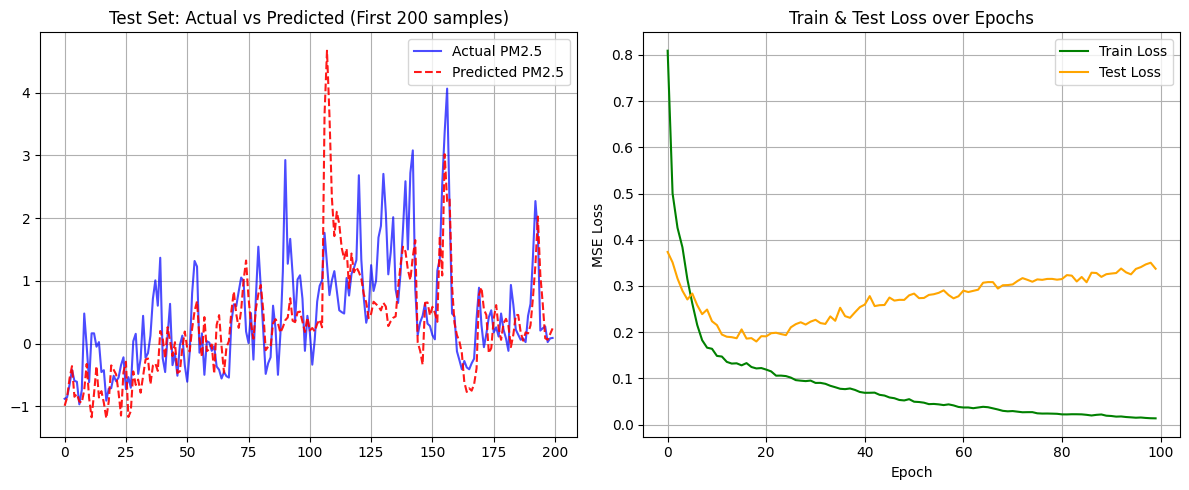

In [4]:
# 2. เตรียมข้อมูลและแบ่ง Train/Test
df = pd.read_csv("CLEAN_BIGGEST_CHUNK-weather-PM2.5-data/weather-PM2.5-05T.csv")

# สมมติชื่อคอลัมน์วันที่คือ 'date' (เปลี่ยนตามไฟล์จริงของคุณ)
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y') 

 # สร้าง Features จากวันที่
df['month'] = df['Date'].dt.month
df['day_of_week'] = df['Date'].dt.dayofweek

# Cyclical Encoding (สำคัญมากเพื่อให้ 31 ธันวา ใกล้กับ 1 มกรา)
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

wind_rad = df['Wind Dir'] * np.pi / 180

# สร้าง Feature ใหม่ 2 ตัว
df['wind_dir_sin'] = np.sin(wind_rad)
df['wind_dir_cos'] = np.cos(wind_rad)

# หลังจากนั้นลบคอลัมน์ Wind Dir เดิมทิ้ง
df = df.drop(columns=['Wind Dir'])

num_df = df.select_dtypes(include=[np.number]).drop(columns=['month'], errors='ignore')

train_size = int(len(num_df) * 0.8)
train_df = num_df.iloc[:train_size].copy()
print(train_df.head())
test_df = num_df.iloc[train_size:].copy()


scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

target_idx = num_df.columns.get_loc('PM2.5')
window_size = 30

train_dataset = PMDataset(train_scaled, target_idx, window_size)
test_dataset = PMDataset(test_scaled, target_idx, window_size)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
print(len(train_loader))
# Test loader ไม่ต้อง shuffle เพื่อให้ plot กราฟตามลำดับเวลาได้
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# 3. Model (คงเดิม)
model = PM25_LSTM(input_size=num_df.shape[1], hidden_size=64, num_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 4. Training Loop with evaluation each epoch
EPOCHS = 100 
train_losses = []
test_losses_per_epoch = []

for epoch in range(EPOCHS):
    # --- Train ---
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Evaluate on test set each epoch ---
    model.eval()
    test_epoch_loss = 0
    with torch.no_grad():
        for X_test, y_test in test_loader:
            preds = model(X_test)
            loss = criterion(preds, y_test)
            test_epoch_loss += loss.item()
    avg_test_loss = test_epoch_loss / len(test_loader)
    test_losses_per_epoch.append(avg_test_loss)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

# 5. Final Evaluation & Plotting
model.eval()
all_preds = []
all_actuals = []
with torch.no_grad():
    for X_test, y_test in test_loader:
        preds = model(X_test)
        all_preds.extend(preds.numpy())
        all_actuals.extend(y_test.numpy())

test_r2 = r2_score(all_actuals, all_preds)
print(f"\nTest R² Score: {test_r2:.4f}")

# Plot กราฟ
plt.figure(figsize=(12, 5))

# กราฟเปรียบเทียบค่าจริง vs ค่าทำนาย
plt.subplot(1, 2, 1)
plt.plot(all_actuals[:200], label='Actual PM2.5', color='blue', alpha=0.7)
plt.plot(all_preds[:200], label='Predicted PM2.5', color='red', linestyle='--', alpha=0.9)
plt.title('Test Set: Actual vs Predicted (First 200 samples)')
plt.legend()
plt.grid(True)

# กราฟ Train & Test Loss รวมกัน
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', color='green')
plt.plot(test_losses_per_epoch, label='Test Loss', color='orange')
plt.title('Train & Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()